1. Imports and Libraries

In [20]:
import os 
import librosa
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold # StratifiedKFold for cross-validation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.regularizers import l2, l1_l2 # l2: L2 regularization that penalizes weights that are too large, l1_l2: Combined L1 and L2 regularization that penalizes weights that are too large and null weights
from tqdm import tqdm
import joblib # For saving the model

2. Centralized Model Configuration

In [21]:
# Anti-overfitting configuration
class Config:
    # Paths 
    INPUT_DIR = r"C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\audios"
    WORKING_DIR =  r"C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture"

    # Audio parameters
    TARGET_LENGTH = 3 
    SR = 16000
    N_MFCC = 13 # Number of MFCC coefficients
    N_MELS = 64
    HOP_LENGTH = 512
    N_FFT = 1024

    # Model parameters
    EPOCHS = 80 # Many but with strict early stopping 
    BATCH_SIZE = 32 # Increased it for more stability
    LEARNING_RATE = 0.001 # Lower learning rate to learn more slowly
    DROPOUT_RATE = 0.5 # Higher dropout rate to avoid overfitting

    # Data augmentation
    NOISE_FACTOR = 0.005 # Noise factor for augmentation
    TIME_SHIFT_MS = 500 # Time shift for augmentation

config = Config()

3. Extract Audio Features

In [22]:
def extract_features(y , sr):
    """Simplified feature extraction to avoid overfitting"""

    # Basic MFCC only 
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=config.N_MFCC, n_fft=config.N_FFT, hop_length=config.HOP_LENGTH)

    # Add only MFCC delta derivative 
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_combined = np.concatenate([mfcc, mfcc_delta], axis=0)

    return mfcc_combined

4. Light Augmentation

In [23]:
def augmentation(y,sr):
    """Minimal augmentation to avoid overfitting"""
    augmented_data = []
    original_length = len(y)

    # Copy of original audio to preserve the original version
    augmented_data.append(y.copy()) 

    # 1st augmentation: Adding light noise
    noise = np.random.normal(0, config.NOISE_FACTOR, original_length)
    noisy_audio = y + noise
    augmented_data.append(noisy_audio)

    # 2nd augmentation: Amplitude change
    amplitude_factor = np.random.uniform(0.8, 1.2) # 0.8 to 1.2 to avoid extremes
    y_amplified = y * amplitude_factor
    augmented_data.append(y_amplified)

    return augmented_data

5. Audio Loading and Processing

In [24]:
# Main idea of this function: 
# Transform audio files into numerical "identity cards" (features) that the computer can understand and compare.
# Final goal: Have perfectly prepared data so that an AI program can learn to recognize different types of sounds.

def load_and_preprocess_data(input_dir, use_augmentation=True, max_samples_per_class=None):
    """Audio Loading and Preprocessing"""
    all_features = []
    labels = []
    file_paths = [] # To keep track of file paths (tracking)

    class_folders = [f for f in os.listdir(input_dir) if os.path.isdir(os.path.join(input_dir, f))]
    print(f"Detected classes: {class_folders}")

    expected_time_steps = None

    for class_name in tqdm(class_folders, desc="Processing classes"):
        class_dir = os.path.join(input_dir, class_name)
        
        # Limit the number of samples per class if specified
        files = [f for f in os.listdir(class_dir) if f.endswith(".wav")]
        if max_samples_per_class:
            files = files[:max_samples_per_class]
        
        for file in tqdm(files, desc=f"Files {class_name}", leave=False):
            file_path = os.path.join(class_dir, file)

            try:
                # Loading
                y, sr = librosa.load(file_path, sr=config.SR)
                y = librosa.util.normalize(y)
                
                # Trimming/padding
                target_samples = config.TARGET_LENGTH * config.SR
                if len(y) > target_samples:
                    start = (len(y) - target_samples) // 2
                    y = y[start:start + target_samples]
                else:
                    y = np.pad(y, (0, max(0, target_samples - len(y))))
                
                y = y[:target_samples]
                
                # Reduced augmentation
                audio_samples = augmentation(y, config.SR) if use_augmentation else [y]

                for audio in audio_samples:
                    if len(audio) != target_samples:
                        if len(audio) > target_samples:
                            audio = audio[:target_samples]
                        else:
                            audio = np.pad(audio, (0, target_samples - len(audio)))
                    
                    # Simplified features
                    mfcc_features = extract_features(audio, config.SR)
                    
                    if expected_time_steps is None:
                        expected_time_steps = mfcc_features.shape[1]
                        print(f"Features shape defined: {mfcc_features.shape}")

                    # Dimension standardization
                    if mfcc_features.shape[1] != expected_time_steps:
                        if mfcc_features.shape[1] > expected_time_steps:
                            mfcc_features = mfcc_features[:, :expected_time_steps]
                        else:
                            pad_width = expected_time_steps - mfcc_features.shape[1]
                            mfcc_features = np.pad(mfcc_features, ((0, 0), (0, pad_width)), mode='constant')
                    
                    all_features.append(mfcc_features.T)
                    labels.append(class_name)
                    file_paths.append(file_path)
                        
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                continue

    X = np.array(all_features)
    print(f"Final features shape: {X.shape}")

    return X, labels, file_paths

5. Model Creation

In [25]:
def create_regularized_model(input_shape, num_classes):
    """Simple model with strong regularization"""
    
    inputs = tf.keras.Input(shape=input_shape) # Input for extracted features
    
    
    # Block 1 - Fewer filters
    x = tf.keras.layers.Conv2D(32, (3,3), activation='relu', 
                              kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    
    # Block 2
    x = tf.keras.layers.Conv2D(64, (3,3), activation='relu',
                              kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    # Block 3 - Last conv block
    x = tf.keras.layers.Conv2D(128, (3,3), activation='relu',
                              kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.6)(x)
    
    # Reduced dense layers
    x = tf.keras.layers.Dense(128, activation='relu', 
                             kernel_regularizer=l1_l2(l1=0.001, l2=0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(config.DROPOUT_RATE)(x)
    
    # No intermediate dense layer - directly to output
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # More conservative optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.LEARNING_RATE, 
                                       beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

7. Training with Callbacks

In [26]:
def train_with_strict_early_stopping(model, X_train, y_train, X_val, y_val):
    """Training with very strict early stopping"""
    
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}")
    print(f"y_val shape: {y_val.shape}")
    
    # VERY strict early stopping
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',  # Monitor the loss, not the accuracy: the lower the loss, the better, otherwise we stop training if no improvement
        patience=8,  # Patience: the number of epochs without improvement before stopping
        restore_best_weights=True,
        verbose=1, # Display early stopping messages
        mode='min', # It's a loss, so we want to minimize it
        min_delta=0.001  # That is, the loss must decrease by at least 0.001 to be considered an improvement
    )
    
    # Aggressive learning rate reduction
    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5,  # Division by 2
        patience=4,  # Very short patience
        min_lr=1e-7, # Minimum learning rate: to prevent the model from learning too fast and overfitting
        verbose=1, # Display learning rate reduction messages
        mode='min'
    )
    
    # Save the best model
    model_checkpoint = callbacks.ModelCheckpoint(
        os.path.join(config.WORKING_DIR, 'best_model.h5'),
        monitor='val_loss',  # Monitor the loss
        save_best_only=True,
        verbose=1,
        mode='min'
    )
    
    # Adaptive batch size: this is the number of samples per batch, adjusted to avoid small batches
    # If the number of training samples is too small, we use a batch size of 1 
    train_samples = X_train.shape[0] # X_train.shape[0] gives the number of training samples
    batch_size = min(config.BATCH_SIZE, train_samples // 8) # That is, the batch size is at most 1/8 of the number of training samples
    if batch_size < 1:
        batch_size = 1
    
    print(f"Batch size used: {batch_size}")
    
    # Training
    history = model.fit(
        X_train, y_train,
        epochs=config.EPOCHS,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr, model_checkpoint],
        verbose=1,
        shuffle=True
    )
    
    return history

8. Plot Training History

In [27]:
def plot_training_history(history):
    """Visualize training to detect overfitting"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5)) # i.e., the graphs will be side by side (code: 1,2: 1 row, 2 columns)
    
    # Loss
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss per Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy
    ax2.plot(history.history['accuracy'], label='Train Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Accuracy per Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Display final metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    print(f"\n=== FINAL METRICS ===")
    print(f"Train Accuracy: {final_train_acc:.4f}")
    print(f"Validation Accuracy: {final_val_acc:.4f}")
    print(f"Train Loss: {final_train_loss:.4f}")
    print(f"Validation Loss: {final_val_loss:.4f}")
    print(f"Accuracy Gap: {abs(final_train_acc - final_val_acc):.4f}")
    print(f"Loss Gap: {abs(final_val_loss - final_train_loss):.4f}")
    
    # Overfitting detection
    if abs(final_train_acc - final_val_acc) > 0.1:
        print("⚠️  OVERFITTING DETECTED: Accuracy gap > 10%")
    if final_val_loss > final_train_loss * 1.5:
        print("⚠️  OVERFITTING DETECTED: Val loss >> Train loss")

9. Main Script

=== DATA LOADING ===
Detected classes: ['alternator_pulley', 'belt_squeal', 'exhaust_leak', 'Fuel injector', 'knocking', 'normale', 'water_pump']


Processing classes:   0%|          | 0/7 [00:00<?, ?it/s]

Features shape defined: (26, 94)


Processing classes: 100%|██████████| 7/7 [00:04<00:00,  1.53it/s]


Final features shape: (1050, 94, 26)

Data loaded:
- Features shape: (1050, 94, 26, 1)
- Number of samples: 1050
- Classes: ['Fuel injector' 'alternator_pulley' 'belt_squeal' 'exhaust_leak'
 'knocking' 'normale' 'water_pump']
- Distribution:
  * Fuel injector: 150 samples
  * alternator_pulley: 150 samples
  * belt_squeal: 150 samples
  * exhaust_leak: 150 samples
  * knocking: 150 samples
  * normale: 150 samples
  * water_pump: 150 samples

Data split:
- Train: 630 samples (60.0%)
- Validation: 210 samples (20.0%)
- Test: 210 samples (20.0%)

=== REGULARIZED MODEL CREATION ===


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 94, 26, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 92, 24, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 92, 24, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 46, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 46, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 44, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 44, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 5, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 22, 5, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 3, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 20, 3, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,495 (435.53 KB)

 Trainable params: 110,791 (432.78 KB)

 Non-trainable params: 704 (2.75 KB)


=== STRICT TRAINING ===
X_train shape: (630, 94, 26, 1)
y_train shape: (630,)
X_val shape: (210, 94, 26, 1)
y_val shape: (210,)
Batch size used: 32
Epoch 1/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2048 - loss: 7.1818
Epoch 1: val_loss improved from None to 6.75839, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.2810 - loss: 6.7647 - val_accuracy: 0.2429 - val_loss: 6.7584 - learning_rate: 0.0010
Epoch 2/80
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3888 - loss: 6.1537
Epoch 2: val_loss improved from 6.75839 to 6.51670, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4111 - loss: 6.0984 - val_accuracy: 0.1571 - val_loss: 6.5167 - learning_rate: 0.0010
Epoch 3/80
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5328 - loss: 5.6581
Epoch 3: val_loss improved from 6.51670 to 6.04868, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5397 - loss: 5.5675 - val_accuracy: 0.1905 - val_loss: 6.0487 - learning_rate: 0.0010
Epoch 4/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6318 - loss: 5.1974
Epoch 4: val_loss improved from 6.04868 to 5.27469, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6111 - loss: 5.2283 - val_accuracy: 0.5333 - val_loss: 5.2747 - learning_rate: 0.0010
Epoch 5/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6486 - loss: 5.0333
Epoch 5: val_loss improved from 5.27469 to 4.93837, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6698 - loss: 4.9673 - val_accuracy: 0.8476 - val_loss: 4.9384 - learning_rate: 0.0010
Epoch 6/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6903 - loss: 4.7939
Epoch 6: val_loss improved from 4.93837 to 4.69543, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6889 - loss: 4.7521 - val_accuracy: 0.8714 - val_loss: 4.6954 - learning_rate: 0.0010
Epoch 7/80
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7515 - loss: 4.5029
Epoch 7: val_loss improved from 4.69543 to 4.45385, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7413 - loss: 4.4936 - val_accuracy: 0.8762 - val_loss: 4.4539 - learning_rate: 0.0010
Epoch 8/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7741 - loss: 4.3657
Epoch 8: val_loss improved from 4.45385 to 4.31137, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7810 - loss: 4.3194 - val_accuracy: 0.8429 - val_loss: 4.3114 - learning_rate: 0.0010
Epoch 9/80
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7861 - loss: 4.1100
Epoch 9: val_loss improved from 4.31137 to 4.15051, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8048 - loss: 4.0831 - val_accuracy: 0.7762 - val_loss: 4.1505 - learning_rate: 0.0010
Epoch 10/80
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8079 - loss: 3.9882
Epoch 10: val_loss improved from 4.15051 to 4.04677, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8333 - loss: 3.9247 - val_accuracy: 0.7381 - val_loss: 4.0468 - learning_rate: 0.0010
Epoch 11/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8508 - loss: 3.7623
Epoch 11: val_loss improved from 4.04677 to 3.94155, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8444 - loss: 3.7672 - val_accuracy: 0.7048 - val_loss: 3.9416 - learning_rate: 0.0010
Epoch 12/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8663 - loss: 3.6636
Epoch 12: val_loss did not improve from 3.94155
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8524 - loss: 3.6310 - val_accuracy: 0.7238 - val_loss: 3.9573 - learning_rate: 0.0010
Epoch 13/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8557 - loss: 3.5247
Epoch 13: val_loss improved from 3.94155 to 3.57691, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8571 - loss: 3.4908 - val_accuracy: 0.8143 - val_loss: 3.5769 - learning_rate: 0.0010
Epoch 14/80
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8856 - loss: 3.3828
Epoch 14: val_loss improved from 3.57691 to 3.53380, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8873 - loss: 3.3628 - val_accuracy: 0.7667 - val_loss: 3.5338 - learning_rate: 0.0010
Epoch 15/80
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9177 - loss: 3.2128
Epoch 15: val_loss improved from 3.53380 to 3.38603, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9159 - loss: 3.1772 - val_accuracy: 0.7857 - val_loss: 3.3860 - learning_rate: 0.0010
Epoch 16/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8664 - loss: 3.1772
Epoch 16: val_loss did not improve from 3.38603
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8825 - loss: 3.1199 - val_accuracy: 0.7429 - val_loss: 3.4773 - learning_rate: 0.0010
Epoch 17/80
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9388 - loss: 2.9412
Epoch 17: val_loss improved from 3.38603 to 3.20046, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9159 - loss: 2.9653 - val_accuracy: 0.8095 - val_loss: 3.2005 - learning_rate: 0.0010
Epoch 18/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9123 - loss: 2.9332
Epoch 18: val_loss improved from 3.20046 to 3.13113, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9159 - loss: 2.8870 - val_accuracy: 0.8000 - val_loss: 3.1311 - learning_rate: 0.0010
Epoch 19/80
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9065 - loss: 2.7777
Epoch 19: val_loss improved from 3.13113 to 2.98698, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9159 - loss: 2.7512 - val_accuracy: 0.8095 - val_loss: 2.9870 - learning_rate: 0.0010
Epoch 20/80
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9410 - loss: 2.6723
Epoch 20: val_loss improved from 2.98698 to 2.91480, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9349 - loss: 2.6459 - val_accuracy: 0.8000 - val_loss: 2.9148 - learning_rate: 0.0010
Epoch 21/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9401 - loss: 2.5819
Epoch 21: val_loss improved from 2.91480 to 2.83538, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9302 - loss: 2.5894 - val_accuracy: 0.8190 - val_loss: 2.8354 - learning_rate: 0.0010
Epoch 22/80
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9274 - loss: 2.5034
Epoch 22: val_loss did not improve from 2.83538
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9143 - loss: 2.5224 - val_accuracy: 0.7429 - val_loss: 3.0318 - learning_rate: 0.0010
Epoch 23/80
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9404 - loss: 2.4350
Epoch 23: val_loss improved from 2.83538 to 2.72370, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9302 - loss: 2.4560 - val_accuracy: 0.8524 - val_loss: 2.7237 - learning_rate: 0.0010
Epoch 24/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9247 - loss: 2.3795
Epoch 24: val_loss improved from 2.72370 to 2.39318, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9286 - loss: 2.3431 - val_accuracy: 0.9095 - val_loss: 2.3932 - learning_rate: 0.0010
Epoch 25/80
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9091 - loss: 2.3327
Epoch 25: val_loss did not improve from 2.39318
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9238 - loss: 2.3124 - val_accuracy: 0.8619 - val_loss: 2.5184 - learning_rate: 0.0010
Epoch 26/80
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8983 - loss: 2.3312
Epoch 26: val_loss did not improve from 2.39318
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9222 - loss: 2.2723 - val_accuracy: 0.8762 - val_loss: 2.4313 - learning_rate: 0.0010
Epoch 27/80
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9398 - loss: 2.1519
Epoch 27: val_loss improved from 2.39318 to 2.19945, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9365 - loss: 2.1482 - val_accuracy: 0.9238 - val_loss: 2.1995 - learning_rate: 0.0010
Epoch 28/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9184 - loss: 2.1468
Epoch 28: val_loss did not improve from 2.19945
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9238 - loss: 2.1448 - val_accuracy: 0.8333 - val_loss: 2.3415 - learning_rate: 0.0010
Epoch 29/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9222 - loss: 2.0680
Epoch 29: val_loss did not improve from 2.19945
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9222 - loss: 2.0665 - val_accuracy: 0.8286 - val_loss: 2.3376 - learning_rate: 0.0010
Epoch 30/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9566 - loss: 1.9793
Epoch 30: val_loss improved from 2.19945 to 2.03021, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9492 - loss: 1.9796 - val_accuracy: 0.9095 - val_loss: 2.0302 - learning_rate: 0.0010
Epoch 31/80
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9524 - loss: 1.9602
Epoch 31: val_loss did not improve from 2.03021
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9492 - loss: 1.9363 - val_accuracy: 0.8524 - val_loss: 2.2329 - learning_rate: 0.0010
Epoch 32/80
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9387 - loss: 1.8832
Epoch 32: val_loss did not improve from 2.03021
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9492 - loss: 1.8664 - val_accuracy: 0.8810 - val_loss: 2.1525 - learning_rate: 0.0010
Epoch 33/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9637 - loss: 1.7947
Epoch 33: val_loss did not improve from 2.03021
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9571 - loss: 1.8018 - val_accuracy: 0.8286 - val_loss: 2.2215 - learning_rate: 0.0010
Epoch 34/80
18/20 ━━━━━━━━━━━━━━━━━━━━

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9508 - loss: 1.7428 - val_accuracy: 0.8810 - val_loss: 1.9530 - learning_rate: 0.0010
Epoch 35/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9386 - loss: 1.7547
Epoch 35: val_loss did not improve from 1.95303
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9429 - loss: 1.7609 - val_accuracy: 0.8476 - val_loss: 2.1530 - learning_rate: 0.0010
Epoch 36/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9786 - loss: 1.6394
Epoch 36: val_loss did not improve from 1.95303
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9667 - loss: 1.6467 - val_accuracy: 0.8238 - val_loss: 1.9658 - learning_rate: 0.0010
Epoch 37/80
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9510 - loss: 1.6210
Epoch 37: val_loss improved from 1.95303 to 1.78780, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9381 - loss: 1.6439 - val_accuracy: 0.9000 - val_loss: 1.7878 - learning_rate: 0.0010
Epoch 38/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9710 - loss: 1.5821
Epoch 38: val_loss did not improve from 1.78780
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9587 - loss: 1.5778 - val_accuracy: 0.8810 - val_loss: 1.8394 - learning_rate: 0.0010
Epoch 39/80
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9460 - loss: 1.5531
Epoch 39: val_loss improved from 1.78780 to 1.65308, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9508 - loss: 1.5521 - val_accuracy: 0.9095 - val_loss: 1.6531 - learning_rate: 0.0010
Epoch 40/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9663 - loss: 1.4914
Epoch 40: val_loss did not improve from 1.65308
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9619 - loss: 1.5101 - val_accuracy: 0.8048 - val_loss: 1.9992 - learning_rate: 0.0010
Epoch 41/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9676 - loss: 1.4557
Epoch 41: val_loss improved from 1.65308 to 1.52662, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9571 - loss: 1.4589 - val_accuracy: 0.9524 - val_loss: 1.5266 - learning_rate: 0.0010
Epoch 42/80
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9588 - loss: 1.4648
Epoch 42: val_loss improved from 1.52662 to 1.49057, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9683 - loss: 1.4165 - val_accuracy: 0.9190 - val_loss: 1.4906 - learning_rate: 0.0010
Epoch 43/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9628 - loss: 1.3833
Epoch 43: val_loss did not improve from 1.49057
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9508 - loss: 1.4090 - val_accuracy: 0.9000 - val_loss: 1.5355 - learning_rate: 0.0010
Epoch 44/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9680 - loss: 1.3561
Epoch 44: val_loss did not improve from 1.49057
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9556 - loss: 1.3938 - val_accuracy: 0.8190 - val_loss: 1.9331 - learning_rate: 0.0010
Epoch 45/80
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9471 - loss: 1.3909
Epoch 45: val_loss did not improve from 1.49057
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9429 - loss: 1.4052 - val_accuracy: 0.8667 - val_loss: 1.6981 - learning_rate: 0.0010
Epoch 46/80
18/20 ━━━━━━━━━━━━━━━━━━━━

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9587 - loss: 1.3344 - val_accuracy: 0.9286 - val_loss: 1.4541 - learning_rate: 5.0000e-04
Epoch 48/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9729 - loss: 1.2449
Epoch 48: val_loss did not improve from 1.45410
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9714 - loss: 1.2462 - val_accuracy: 0.9333 - val_loss: 1.4579 - learning_rate: 5.0000e-04
Epoch 49/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9740 - loss: 1.1961
Epoch 49: val_loss improved from 1.45410 to 1.45340, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9698 - loss: 1.2090 - val_accuracy: 0.9000 - val_loss: 1.4534 - learning_rate: 5.0000e-04
Epoch 50/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9693 - loss: 1.2200
Epoch 50: val_loss improved from 1.45340 to 1.24936, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9683 - loss: 1.2153 - val_accuracy: 0.9571 - val_loss: 1.2494 - learning_rate: 5.0000e-04
Epoch 51/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9845 - loss: 1.1415
Epoch 51: val_loss did not improve from 1.24936
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9762 - loss: 1.1497 - val_accuracy: 0.9238 - val_loss: 1.2913 - learning_rate: 5.0000e-04
Epoch 52/80
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9681 - loss: 1.1324
Epoch 52: val_loss improved from 1.24936 to 1.22004, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9794 - loss: 1.1131 - val_accuracy: 0.9429 - val_loss: 1.2200 - learning_rate: 5.0000e-04
Epoch 53/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9702 - loss: 1.0833
Epoch 53: val_loss improved from 1.22004 to 1.16118, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9746 - loss: 1.0723 - val_accuracy: 0.9381 - val_loss: 1.1612 - learning_rate: 5.0000e-04
Epoch 54/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9758 - loss: 1.0447
Epoch 54: val_loss improved from 1.16118 to 1.13730, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9778 - loss: 1.0341 - val_accuracy: 0.9476 - val_loss: 1.1373 - learning_rate: 5.0000e-04
Epoch 55/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9883 - loss: 1.0124
Epoch 55: val_loss did not improve from 1.13730
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9825 - loss: 1.0264 - val_accuracy: 0.9381 - val_loss: 1.2049 - learning_rate: 5.0000e-04
Epoch 56/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9705 - loss: 1.0200
Epoch 56: val_loss did not improve from 1.13730
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9667 - loss: 1.0396 - val_accuracy: 0.9381 - val_loss: 1.1997 - learning_rate: 5.0000e-04
Epoch 57/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9722 - loss: 1.0161
Epoch 57: val_loss did not improve from 1.13730
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9841 - loss: 0.9882 - val_accuracy: 0.9048 - val_loss: 1.2555 - learning_rate: 5.0000e-04
Epoch 58/80
19/20 ━━━━

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9651 - loss: 0.9998 - val_accuracy: 0.9619 - val_loss: 1.0687 - learning_rate: 5.0000e-04
Epoch 59/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9664 - loss: 0.9917
Epoch 59: val_loss did not improve from 1.06867
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9508 - loss: 1.0296 - val_accuracy: 0.9048 - val_loss: 1.2205 - learning_rate: 5.0000e-04
Epoch 60/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9723 - loss: 1.0289
Epoch 60: val_loss did not improve from 1.06867
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9619 - loss: 1.0353 - val_accuracy: 0.9190 - val_loss: 1.2004 - learning_rate: 5.0000e-04
Epoch 61/80
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9628 - loss: 1.0408
Epoch 61: val_loss did not improve from 1.06867
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9667 - loss: 1.0387 - val_accuracy: 0.9238 - val_loss: 1.1650 - learning_rate: 5.0000e-04
Epoch 62/80
18/20 ━━━━

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9683 - loss: 0.9545 - val_accuracy: 0.9571 - val_loss: 1.0132 - learning_rate: 2.5000e-04
Epoch 65/80
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9856 - loss: 0.8895
Epoch 65: val_loss improved from 1.01317 to 1.00644, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9857 - loss: 0.8882 - val_accuracy: 0.9571 - val_loss: 1.0064 - learning_rate: 2.5000e-04
Epoch 66/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9769 - loss: 0.8883
Epoch 66: val_loss did not improve from 1.00644
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9730 - loss: 0.8925 - val_accuracy: 0.9524 - val_loss: 1.0436 - learning_rate: 2.5000e-04
Epoch 67/80
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9833 - loss: 0.8678
Epoch 67: val_loss did not improve from 1.00644
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9825 - loss: 0.8798 - val_accuracy: 0.9333 - val_loss: 1.0509 - learning_rate: 2.5000e-04
Epoch 68/80
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9901 - loss: 0.8477
Epoch 68: val_loss improved from 1.00644 to 0.98454, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9857 - loss: 0.8475 - val_accuracy: 0.9571 - val_loss: 0.9845 - learning_rate: 2.5000e-04
Epoch 69/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9851 - loss: 0.8323
Epoch 69: val_loss improved from 0.98454 to 0.97036, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9825 - loss: 0.8350 - val_accuracy: 0.9571 - val_loss: 0.9704 - learning_rate: 2.5000e-04
Epoch 70/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9858 - loss: 0.8587
Epoch 70: val_loss improved from 0.97036 to 0.92750, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9841 - loss: 0.8318 - val_accuracy: 0.9619 - val_loss: 0.9275 - learning_rate: 2.5000e-04
Epoch 71/80
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9752 - loss: 0.8300
Epoch 71: val_loss did not improve from 0.92750
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9810 - loss: 0.8196 - val_accuracy: 0.9333 - val_loss: 0.9909 - learning_rate: 2.5000e-04
Epoch 72/80
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9782 - loss: 0.8233
Epoch 72: val_loss did not improve from 0.92750
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9825 - loss: 0.8139 - val_accuracy: 0.9381 - val_loss: 0.9515 - learning_rate: 2.5000e-04
Epoch 73/80
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9849 - loss: 0.8059
Epoch 73: val_loss improved from 0.92750 to 0.91761, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9841 - loss: 0.8017 - val_accuracy: 0.9571 - val_loss: 0.9176 - learning_rate: 2.5000e-04
Epoch 74/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9884 - loss: 0.7784
Epoch 74: val_loss improved from 0.91761 to 0.91116, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9857 - loss: 0.7836 - val_accuracy: 0.9571 - val_loss: 0.9112 - learning_rate: 2.5000e-04
Epoch 75/80
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9914 - loss: 0.7723
Epoch 75: val_loss did not improve from 0.91116
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9873 - loss: 0.7757 - val_accuracy: 0.9571 - val_loss: 0.9219 - learning_rate: 2.5000e-04
Epoch 76/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9856 - loss: 0.7793
Epoch 76: val_loss improved from 0.91116 to 0.88285, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9873 - loss: 0.7613 - val_accuracy: 0.9619 - val_loss: 0.8829 - learning_rate: 2.5000e-04
Epoch 77/80
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9807 - loss: 0.7703
Epoch 77: val_loss improved from 0.88285 to 0.87340, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9857 - loss: 0.7682 - val_accuracy: 0.9667 - val_loss: 0.8734 - learning_rate: 2.5000e-04
Epoch 78/80
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9831 - loss: 0.7810
Epoch 78: val_loss did not improve from 0.87340
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9889 - loss: 0.7438 - val_accuracy: 0.9476 - val_loss: 0.9329 - learning_rate: 2.5000e-04
Epoch 79/80
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9865 - loss: 0.7316
Epoch 79: val_loss improved from 0.87340 to 0.85194, saving model to C:\Users\naima\OneDrive\Desktop\Work\Modèle_Panne_Voiture\best_model.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9857 - loss: 0.7371 - val_accuracy: 0.9619 - val_loss: 0.8519 - learning_rate: 2.5000e-04
Epoch 80/80
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9784 - loss: 0.7433
Epoch 80: val_loss did not improve from 0.85194
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9810 - loss: 0.7397 - val_accuracy: 0.9619 - val_loss: 0.8802 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 79.

=== TRAINING ANALYSIS ===


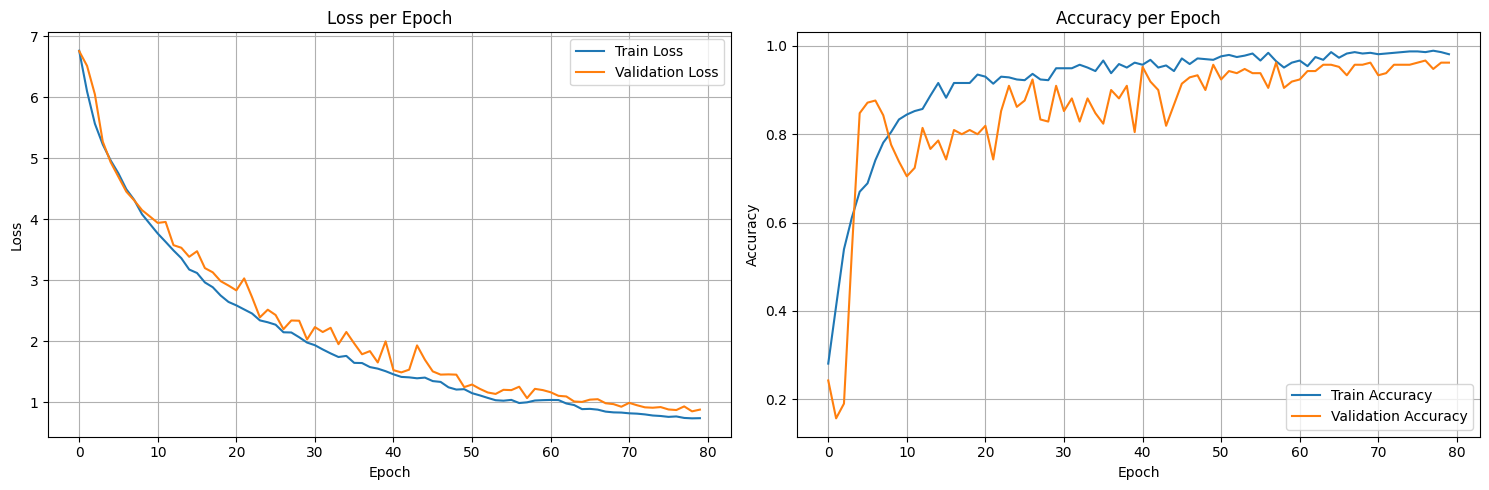


=== FINAL METRICS ===
Train Accuracy: 0.9810
Validation Accuracy: 0.9619
Train Loss: 0.7397
Validation Loss: 0.8802
Accuracy Gap: 0.0190
Loss Gap: 0.1405

=== FINAL EVALUATION ===
Test Accuracy: 0.9714
Test Loss: 0.7680


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001EE0EDBB9C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

=== CLASSIFICATION REPORT ===


                   precision    recall  f1-score   support

    Fuel injector       0.91      1.00      0.95        30
alternator_pulley       0.97      1.00      0.98        30
      belt_squeal       1.00      1.00      1.00        30
     exhaust_leak       1.00      0.83      0.91        30
         knocking       1.00      0.97      0.98        30
          normale       1.00      1.00      1.00        30
       water_pump       0.94      1.00      0.97        30

         accuracy                           0.97       210
        macro avg       0.97      0.97      0.97       210
     weighted avg       0.97      0.97      0.97       210


=== SAVING ===
Model saved successfully!


In [28]:
def main():
    print("=== DATA LOADING ===")
    # Limit samples per class to reduce overfitting
    X, labels, file_paths = load_and_preprocess_data(
        config.INPUT_DIR, 
        use_augmentation=True,
        max_samples_per_class=50  # Limit to max 50 samples per class
    )
    
    # Add channel dimension
    X = X[..., np.newaxis]
    
    print(f"\nData loaded:")
    print(f"- Features shape: {X.shape}")
    print(f"- Number of samples: {len(labels)}")
    
    # Label encoding
    encoder = LabelEncoder()
    y = encoder.fit_transform(labels)
    
    print(f"- Classes: {encoder.classes_}")
    print(f"- Distribution:")
    unique, counts = np.unique(labels, return_counts=True)
    for class_name, count in zip(unique, counts):
        print(f"  * {class_name}: {count} samples")
    
    # Stratified split with separate validation: this is useful to ensure that each class is represented equally in the training, validation, and test sets
    X_temp, X_test, y_temp, y_test = train_test_split( 
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 0.25 * 0.8 = 0.2 of total
    )
    
    print(f"\nData split:")
    print(f"- Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"- Validation: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
    print(f"- Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
    
    # Creating regularized model
    print("\n=== REGULARIZED MODEL CREATION ===")
    model = create_regularized_model(X.shape[1:], len(encoder.classes_))
    model.summary()
    
    # Strict training
    print("\n=== STRICT TRAINING ===")
    history = train_with_strict_early_stopping(model, X_train, y_train, X_val, y_val)
    
    # Training visualization
    print("\n=== TRAINING ANALYSIS ===")
    plot_training_history(history)
    
    # Final evaluation on test
    print("\n=== FINAL EVALUATION ===")

    
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Detailed predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    print("\n=== CLASSIFICATION REPORT ===")
    print(classification_report(y_test, y_pred_classes, 
                              target_names=encoder.classes_))
    
    # Saving
    print("\n=== SAVING ===")
    model.save(os.path.join(config.WORKING_DIR, 'model.h5'))
    joblib.dump(encoder, os.path.join(config.WORKING_DIR, 'model_encoder.joblib'))
    
    print("Model saved successfully!")
    
    return model, encoder, history

if __name__ == "__main__":
    model, encoder, history = main()